In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Условия задачи
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).


Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

# Флоу обработки партии 
- сталь заливают в ковш
- подогревают до нужной температуры
- выводится сера, добавляются примеси и отбираются пробы
- измеряют температуру
- проводят хим.анализ
- повышают температуру
- добавляют легирующие материалы
- продувают сплав инертным газом
- перемешивают
- достигают целевого хим.состава и оптимальной температуры плавки

# Загрузка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

Запретим скролинг в окнах вывода

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Загружаем данные

In [4]:
try:
    
    path = '/content/drive/MyDrive/Colab Notebooks/Industry/'
    
except:

    path = '/datasets/final_steel/'

In [5]:
data_arc = pd.read_csv(path+'data_arc.csv')
data_bulk = pd.read_csv(path+'data_bulk.csv')
data_bulk_time = pd.read_csv(path+'data_bulk_time.csv')
data_gas = pd.read_csv(path+'data_gas.csv')
data_temp = pd.read_csv(path+'data_temp.csv')
data_wire = pd.read_csv(path+'data_wire.csv')
data_wire_time = pd.read_csv(path+'data_wire_time.csv')

# Исследовательский анализ данных

## Данные об электродах - data_arc

In [6]:
data_arc.head(20)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [7]:
data_arc[data_arc['key']==11]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
45,11,2019-05-03 16:49:14,2019-05-03 16:52:03,0.590658,0.431572
46,11,2019-05-03 17:03:01,2019-05-03 17:05:01,0.412197,0.326343
47,11,2019-05-03 17:15:28,2019-05-03 17:16:21,0.172661,0.128043
48,11,2019-05-03 17:20:37,2019-05-03 17:24:16,0.861919,0.627389
49,11,2019-05-03 17:28:01,2019-05-03 17:29:07,0.260076,0.194913


In [8]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [9]:
data_arc['key'].nunique()

3214

In [10]:
data_arc['key'].max()

3241

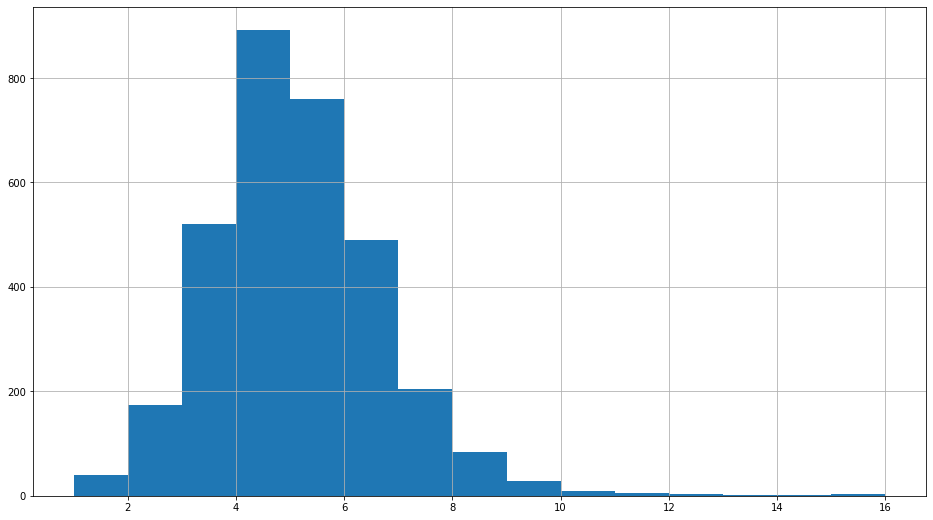

In [11]:
data_arc.groupby('key')['key'].agg('count').hist(figsize=(16,9), bins=15)

Максимум в одной партии происходило до 16ти этапов нагревания.  
Необходимо заменить названия столбцов.  
Таблицу можно свести к двум признакам, либо по числу итераций нагрева.  
Необходимо вычислить время нагрева и умножить на мощность, получим следующие признаки:
- **затраченная на нагрев активная энергия**.  
- **затраченная на нагрев реактивная энергия**.  

Кроме того, начало первого нагрева - это первое зафиксированное в процессе время, его можно считать началом всей операции обработки. Используя начало первого нагрева и время последнего замера температуры можем получить фичу:
- **общее время обработки партии**.

## Данные о подаче сыпучих материалов (объём) - data_bulk

In [12]:
data_bulk.head(20)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [13]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [14]:
data_bulk['key'].nunique()

3129

In [15]:
data_bulk['key'].max()

3241

Не во все партии добавлялись сыпучие материалы.  
Переименуем столбцы (регистр, пропуски).  
Поменяем тип данных на int, это позволит снизит ресурсозатраты.  
Наны заполним нулями.  

## Данные о подаче сыпучих материалов (время) - data_bulk_time

In [16]:
data_bulk_time.head(20)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


In [17]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


На первой итерации проекта не будем использовать эту таблицу, данные в ней кажутся бесполезными.  
На второй итерации можно попробовать вывести признаки:
- **время от начала всего процесса до момента засыпки**
- **время от засыпки до конца всего процесса**

Переименуем столбцы(регистр, пробелы)  
Переведем в datetime. 

## Данные о продувке сплава газом - data_gas

In [18]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [19]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [20]:
data_gas['key'].nunique()

3239

In [21]:
data_gas['key'].max()

3241

Переименуем столбцы  
В двух партиях отсутствует информация о продувке, удалим эти два объекта.

## Результаты измерения температуры - data_temp

In [22]:
data_temp[data_temp['key']==11]

,key,Время замера,Температура
48,11,2019-05-03 16:54:18,1616.0
49,11,2019-05-03 16:57:03,1608.0
50,11,2019-05-03 17:20:27,1583.0
51,11,2019-05-03 17:27:23,1597.0


In [23]:
data_temp.head(20)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


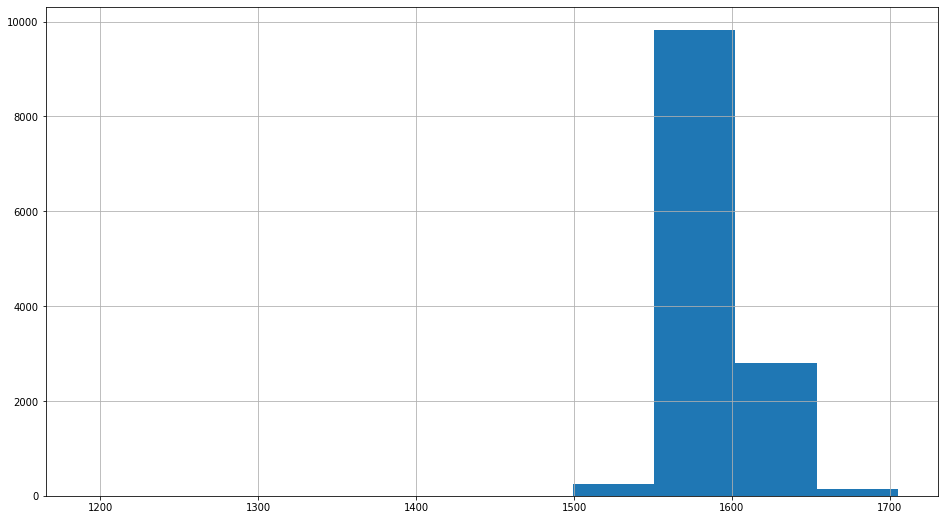

In [24]:
data_temp['Температура'].hist(figsize=(16,9), grid=True)

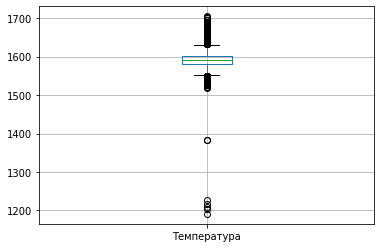

In [25]:
data_temp.boxplot('Температура')

In [26]:
data_temp['Температура'].describe()

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

Много выбросов, разница в 500 градусов кажется очень подозрительной.  
Нужно узнать количество наблюдений, в которых температура ниже температуры плавления стали(1450градусов).  
Необходимо экспертное мнение, для признания выбросами показаний температуры, менее удалённых от среднего.

In [27]:
data_temp[data_temp['Температура'] < 1450].count()

key             7
Время замера    7
Температура     7
dtype: int64

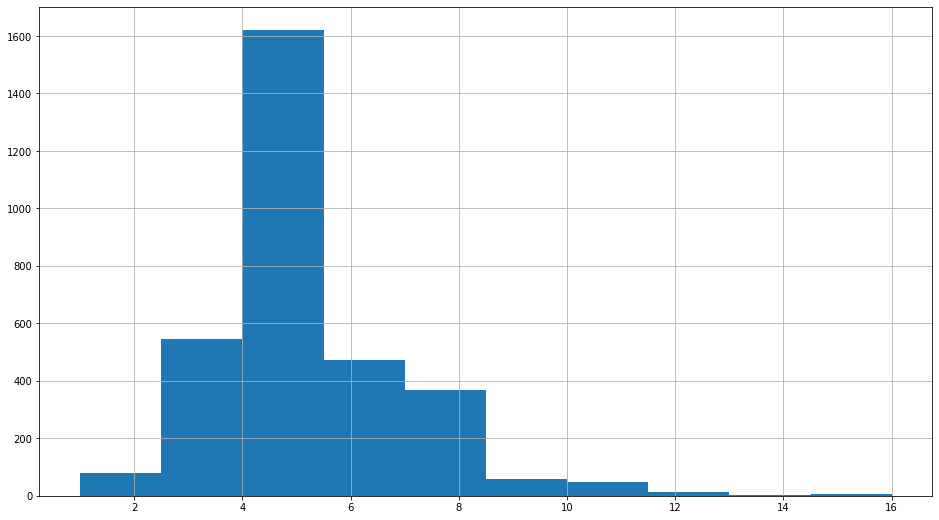

In [28]:
data_temp.groupby('key')['key'].agg('count').hist(figsize=(16,9), grid=True)

In [29]:
t = pd.DataFrame(data_temp.groupby('key')['key'].agg('count'))
t[t['key']==16]

,key
key,
44,16
46,16
1214,16
1513,16


In [30]:
len(t[t['key']>=12])

24

In [31]:
len(t[t['key']>=12]) / len(t)

0.007462686567164179

In [32]:
data_temp[data_temp['key']==44]

,key,Время замера,Температура
225,44,2019-05-04 22:13:44,1600.0
226,44,2019-05-04 22:32:26,1608.0
227,44,2019-05-04 22:39:37,1619.0
228,44,2019-05-04 22:43:49,1600.0
229,44,2019-05-04 22:44:29,1605.0
230,44,2019-05-04 22:46:49,1601.0
231,44,2019-05-04 22:47:20,1601.0
232,44,2019-05-04 22:50:26,1607.0
233,44,2019-05-05 00:35:31,1570.0
234,44,2019-05-05 00:48:32,1599.0


In [33]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [34]:
data_temp['key'].nunique()

3216

In [35]:
data_temp['key'].max()

3241

In [36]:
t = data_temp.groupby(['key'])['Время замера'].agg(['max'])
t.columns = ['Время замера']
t_2 = t.merge(data_temp, on = 'Время замера', how = 'left')
t_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Время замера  3216 non-null   object 
 1   key           3216 non-null   int64  
 2   Температура   2477 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 100.5+ KB


Сохраним список партий, в которых отсутствует целевой признак

In [37]:
null_part = pd.Series(t_2[t_2['Температура'].isnull()]['key'])

In [38]:
null_part

2477    2500
2478    2501
2479    2502
2480    2503
2481    2504
        ... 
3211    3237
3212    3238
3213    3239
3214    3240
3215    3241
Name: key, Length: 739, dtype: int64

In [39]:
t_2[t_2['Температура'].isnull()]

,Время замера,key,Температура
2477,2019-08-06 03:28:21,2500,NaN
2478,2019-08-06 04:31:14,2501,NaN
2479,2019-08-06 05:12:20,2502,NaN
2480,2019-08-06 06:07:35,2503,NaN
2481,2019-08-06 07:04:16,2504,NaN
...,...,...,...
3211,2019-08-31 23:05:43,3237,NaN
3212,2019-08-31 23:43:00,3238,NaN
3213,2019-09-01 02:24:15,3239,NaN
3214,2019-09-01 03:35:16,3240,NaN


In [40]:
data_temp.tail(20)

,key,Время замера,Температура
15887,3239,2019-09-01 01:42:46,NaN
15888,3239,2019-09-01 01:48:00,NaN
15889,3239,2019-09-01 01:59:27,NaN
15890,3239,2019-09-01 02:13:30,NaN
15891,3239,2019-09-01 02:22:15,NaN
15892,3239,2019-09-01 02:23:02,NaN
15893,3239,2019-09-01 02:24:15,NaN
15894,3240,2019-09-01 02:39:01,1617.0
15895,3240,2019-09-01 02:48:33,NaN
15896,3240,2019-09-01 03:03:21,NaN


Одна партия могла нагреваться до 16ти раз.  
Всего 24 партии нагревались 12-16раз, а это менее 1%. В дальнейшем можно будет удалить объекты, где число нагреваний первышает 11, но данных и так не очень много.  
Только в 2477 партиях у нас имеются данные о последнем замере температуры.  
Остальные партии не имеют целевого признака, их необходимо дропнуть.  


Все партии начиная с **2500** не имеют данных о последнем замере температуры!

## Данные о проволочных материалах (объём) - data_wire

In [41]:
data_wire.head(20)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [43]:
data_wire['key'].nunique()

3081

In [44]:
data_wire['key'].max()

3241

Не во всех партиях проволока добавлялась в сплав.  
Наны можно заменить нулями. Заменять наны надо после присоединения к основной таблице.   
Столбцы переименовать (регистр, пробелы)

## Данные о проволочных материалах (время) - data_wire_time

In [45]:
data_wire_time.head(20)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [47]:
data_wire_time['key'].nunique()

3081

Так же как и с временем засыпки, время подачи проволоки кажется бесполезным.  
На первой итерации проекта не будем использовать эту таблицу, данные в ней кажутся бесполезными.
На второй итерации можно попробовать вывести признаки:
- время от начала всего процесса до момента подачи проволоки
- время от подачи проволоки до окончания всего процесса

Переименуем столбцы(регистр, пробелы)
Переведем в datetime.


## План работ
- все партии начиная с 2500 не имеют данных о последнем замере температуры, удалить из всех таблиц партии 2500+;
- провести запланированные преобразования в каждой из таблиц;
- собрать общую таблицу, мерджить по ключам;
- обнулить информацию о процессах, происходящих позже последнего замера температуры;
- обучить модели LinearRegression, RandomForestRegressor, CatBoostRegressor, LGBMRegressor, XGBRegressor;
- получить MAE < 6.0, 7sp;

In [48]:
bad_part = 2500

# Предобработка данных

Удалим партии в которых отсутствует целевой признак

In [49]:
data_arc = data_arc[data_arc['key'] < bad_part]
data_bulk = data_bulk[data_bulk['key'] < bad_part]
data_bulk_time = data_bulk_time[data_bulk_time['key'] < bad_part]
data_gas = data_gas[data_gas['key'] < bad_part]
data_temp = data_temp[data_temp['key'] < bad_part]
data_wire = data_wire[data_wire['key'] < bad_part]
data_wire_time = data_wire_time[data_wire_time['key'] < bad_part]

Удалим партии, в которых температура материала ниже температуры плавления стали

In [50]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12267 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           12267 non-null  int64  
 1   Время замера  12267 non-null  object 
 2   Температура   12267 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 383.3+ KB


In [51]:
data_temp = data_temp[data_temp['Температура'] >= 1450]
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12261 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           12261 non-null  int64  
 1   Время замера  12261 non-null  object 
 2   Температура   12261 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 383.2+ KB


## Переименование столбцов

Электроды

In [52]:
data_arc.columns

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Активная мощность', 'Реактивная мощность'],
      dtype='object')

In [53]:
data_arc.columns = ['key', 'start_heat', 'fin_heat', 'act_pow', 'react_pow']

Сыпучие материалы(объем)

In [54]:
data_bulk.columns

Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

In [55]:
data_bulk.columns = data_bulk.columns.str.lower().str.replace(' ', '_')

Сыпучие материалы(время)

In [56]:
data_bulk_time.columns

Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

In [57]:
data_bulk_time.columns = data_bulk_time.columns.str.lower().str.replace(' ', '_')

Газ

In [58]:
data_gas.columns

Index(['key', 'Газ 1'], dtype='object')

In [59]:
data_gas.columns = ['key', 'gas']

Температура


In [60]:
data_temp.columns

Index(['key', 'Время замера', 'Температура'], dtype='object')

In [61]:
data_temp.columns = ['key', 'measurement_time', 'temp']

Проволока(объем)

In [62]:
data_wire.columns

Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

In [63]:
data_wire.columns = data_wire.columns.str.lower().str.replace(' ', '_')

Проволока(время)

In [64]:
data_wire_time.columns

Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

In [65]:
data_wire_time.columns = data_wire_time.columns.str.lower().str.replace(' ', '_')

## Преобразование типов данных и заполнение пропусков

### Электроды

In [66]:
data_arc.head()

,key,start_heat,fin_heat,act_pow,react_pow
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [67]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11449 entries, 0 to 11448
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         11449 non-null  int64  
 1   start_heat  11449 non-null  object 
 2   fin_heat    11449 non-null  object 
 3   act_pow     11449 non-null  float64
 4   react_pow   11449 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 536.7+ KB


In [68]:
data_arc['start_heat'] = pd.to_datetime(data_arc['start_heat'], format='%Y-%m-%d %H:%M:%S')

In [69]:
data_arc['fin_heat'] = pd.to_datetime(data_arc['fin_heat'], format='%Y-%m-%d %H:%M:%S')

### Сыпучие материалы(объем)

In [70]:
data_bulk.head(10)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [71]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2408 entries, 0 to 2407
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      2408 non-null   int64  
 1   bulk_1   199 non-null    float64
 2   bulk_2   13 non-null     float64
 3   bulk_3   965 non-null    float64
 4   bulk_4   814 non-null    float64
 5   bulk_5   53 non-null     float64
 6   bulk_6   444 non-null    float64
 7   bulk_7   14 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   13 non-null     float64
 10  bulk_10  143 non-null    float64
 11  bulk_11  130 non-null    float64
 12  bulk_12  1882 non-null   float64
 13  bulk_13  14 non-null     float64
 14  bulk_14  2137 non-null   float64
 15  bulk_15  1713 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 319.8 KB


Очень мало данных в столбцах bulk_2, bulk_7, bulk_8, bulk_9, bulk_13.  
Удалим из обучения на второй итерации.

In [72]:
bulk = data_bulk.columns.drop('key')

In [73]:
for i in bulk:
  data_bulk[i] = data_bulk[i].fillna(value=0).astype('int')

In [74]:
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154
1,2,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154
2,3,0,0,0,34,0,0,0,0,0,0,0,205,0,152,153
3,4,0,0,0,81,0,0,0,0,0,0,0,207,0,153,154
4,5,0,0,0,78,0,0,0,0,0,0,0,203,0,151,152


### Сыпучие материалы(время)


In [75]:
data_bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [76]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2408 entries, 0 to 2407
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      2408 non-null   int64 
 1   bulk_1   199 non-null    object
 2   bulk_2   13 non-null     object
 3   bulk_3   965 non-null    object
 4   bulk_4   814 non-null    object
 5   bulk_5   53 non-null     object
 6   bulk_6   444 non-null    object
 7   bulk_7   14 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   13 non-null     object
 10  bulk_10  143 non-null    object
 11  bulk_11  130 non-null    object
 12  bulk_12  1882 non-null   object
 13  bulk_13  14 non-null     object
 14  bulk_14  2137 non-null   object
 15  bulk_15  1713 non-null   object
dtypes: int64(1), object(15)
memory usage: 319.8+ KB


In [77]:
bulk_time = data_bulk_time.columns.drop('key')

In [78]:
for i in bulk_time:
  data_bulk_time[i] = pd.to_datetime(data_bulk_time[i], format='%Y-%m-%d %H:%M:%S')

In [79]:
data_bulk_time

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2403,2495,NaT,NaT,2019-08-06 00:49:21,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-06 00:36:47,NaT,2019-08-06 00:32:18,NaT,2019-08-06 00:32:18,2019-08-06 00:32:18
2404,2496,NaT,NaT,NaT,2019-08-06 01:14:16,NaT,NaT,NaT,NaT,NaT,2019-08-06 01:14:16,NaT,2019-08-06 01:06:37,NaT,2019-08-06 01:06:37,2019-08-06 01:06:37
2405,2497,NaT,NaT,NaT,2019-08-06 01:43:02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-06 01:38:54,NaT,2019-08-06 01:38:54,2019-08-06 01:38:53
2406,2498,NaT,NaT,2019-08-06 02:05:26,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-06 02:05:26,NaT,2019-08-06 01:59:25,NaT,2019-08-06 01:59:25,2019-08-06 01:59:25


### Газ


In [80]:
data_gas.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [81]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2497 entries, 0 to 2496
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     2497 non-null   int64  
 1   gas     2497 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 58.5 KB


### Температура

In [82]:
data_temp.head()

,key,measurement_time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [83]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12261 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               12261 non-null  int64  
 1   measurement_time  12261 non-null  object 
 2   temp              12261 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 383.2+ KB


In [84]:
data_temp['measurement_time'] = pd.to_datetime(data_temp['measurement_time'], format='%Y-%m-%d %H:%M:%S')

In [85]:
data_temp['temp'] = data_temp['temp'].astype('int')

In [86]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12261 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               12261 non-null  int64         
 1   measurement_time  12261 non-null  datetime64[ns]
 2   temp              12261 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 383.2 KB


### Проволока(время)

In [87]:
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2373 entries, 0 to 2372
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     2373 non-null   int64  
 1   wire_1  2349 non-null   float64
 2   wire_2  833 non-null    float64
 3   wire_3  39 non-null     float64
 4   wire_4  12 non-null     float64
 5   wire_5  0 non-null      float64
 6   wire_6  45 non-null     float64
 7   wire_7  4 non-null      float64
 8   wire_8  13 non-null     float64
 9   wire_9  28 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 203.9 KB


Для начала удалим только нулевой столбец.  
Вероятнее всего, удаление признаков с очень маленьким количеством данных  положительно повлияет на метрику.  
На второй итерации из обучения необходимо удалить wire_3, wire_4, wire_6, wire_7, wire_8, wire_9.

In [89]:
data_wire = data_wire.drop('wire_5', axis=1).fillna(value=0)

In [90]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2373 entries, 0 to 2372
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     2373 non-null   int64  
 1   wire_1  2373 non-null   float64
 2   wire_2  2373 non-null   float64
 3   wire_3  2373 non-null   float64
 4   wire_4  2373 non-null   float64
 5   wire_6  2373 non-null   float64
 6   wire_7  2373 non-null   float64
 7   wire_8  2373 non-null   float64
 8   wire_9  2373 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 185.4 KB


### Проволока(время)

In [91]:
data_wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2373 entries, 0 to 2372
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     2373 non-null   int64 
 1   wire_1  2349 non-null   object
 2   wire_2  833 non-null    object
 3   wire_3  39 non-null     object
 4   wire_4  12 non-null     object
 5   wire_5  0 non-null      object
 6   wire_6  45 non-null     object
 7   wire_7  4 non-null      object
 8   wire_8  13 non-null     object
 9   wire_9  28 non-null     object
dtypes: int64(1), object(9)
memory usage: 203.9+ KB


Так же как в data_wire, для начала удалим только нулевой столбец.

In [93]:
data_wire_time = data_wire_time.drop('wire_5', axis=1)

# Генерим фичи, собираем общую таблицу

Начнем с температуры

## Температура

In [94]:
data_temp.head(20)

,key,measurement_time,temp
0,1,2019-05-03 11:16:18,1571
1,1,2019-05-03 11:25:53,1604
2,1,2019-05-03 11:29:11,1618
3,1,2019-05-03 11:30:01,1601
4,1,2019-05-03 11:30:39,1613
5,2,2019-05-03 11:37:27,1581
6,2,2019-05-03 11:38:00,1577
7,2,2019-05-03 11:49:38,1589
8,2,2019-05-03 11:55:50,1604
9,2,2019-05-03 11:58:24,1608


In [95]:
df = data_temp.groupby('key').agg({'measurement_time':'min'}).merge(data_temp, on=['key', 'measurement_time'], how='left')

In [96]:
df.columns = ['key', 'first_meas', 'first_temp']

In [97]:
df.head()

,key,first_meas,first_temp
0,1,2019-05-03 11:16:18,1571
1,2,2019-05-03 11:37:27,1581
2,3,2019-05-03 12:13:17,1596
3,4,2019-05-03 12:52:57,1601
4,5,2019-05-03 13:23:19,1576


In [98]:
t = data_temp.groupby('key').agg({'measurement_time':'max'}).merge(data_temp, on=['key', 'measurement_time'], how='left')
t.columns = ['key', 'last_meas', 'last_temp']
t

,key,last_meas,last_temp
0,1,2019-05-03 11:30:39,1613
1,2,2019-05-03 11:59:12,1602
2,3,2019-05-03 12:34:57,1599
3,4,2019-05-03 12:59:25,1625
4,5,2019-05-03 13:36:01,1602
...,...,...,...
2472,2495,2019-08-06 00:54:42,1591
2473,2496,2019-08-06 01:29:52,1591
2474,2497,2019-08-06 01:53:50,1589
2475,2498,2019-08-06 02:25:31,1594


In [99]:
df = df.merge(t, on='key', how='left')
df.head()

,key,first_meas,first_temp,last_meas,last_temp
0,1,2019-05-03 11:16:18,1571,2019-05-03 11:30:39,1613
1,2,2019-05-03 11:37:27,1581,2019-05-03 11:59:12,1602
2,3,2019-05-03 12:13:17,1596,2019-05-03 12:34:57,1599
3,4,2019-05-03 12:52:57,1601,2019-05-03 12:59:25,1625
4,5,2019-05-03 13:23:19,1576,2019-05-03 13:36:01,1602


In [100]:
data_temp.head(20)

,key,measurement_time,temp
0,1,2019-05-03 11:16:18,1571
1,1,2019-05-03 11:25:53,1604
2,1,2019-05-03 11:29:11,1618
3,1,2019-05-03 11:30:01,1601
4,1,2019-05-03 11:30:39,1613
5,2,2019-05-03 11:37:27,1581
6,2,2019-05-03 11:38:00,1577
7,2,2019-05-03 11:49:38,1589
8,2,2019-05-03 11:55:50,1604
9,2,2019-05-03 11:58:24,1608


In [101]:
df['time_btw_meas'] = df['last_meas'] - df['first_meas']

In [102]:
df.head()

,key,first_meas,first_temp,last_meas,last_temp,time_btw_meas
0,1,2019-05-03 11:16:18,1571,2019-05-03 11:30:39,1613,0 days 00:14:21
1,2,2019-05-03 11:37:27,1581,2019-05-03 11:59:12,1602,0 days 00:21:45
2,3,2019-05-03 12:13:17,1596,2019-05-03 12:34:57,1599,0 days 00:21:40
3,4,2019-05-03 12:52:57,1601,2019-05-03 12:59:25,1625,0 days 00:06:28
4,5,2019-05-03 13:23:19,1576,2019-05-03 13:36:01,1602,0 days 00:12:42


In [103]:
df['time_btw_meas'] = df['time_btw_meas'].astype('timedelta64[s]').astype('int')

In [104]:
df.head()

,key,first_meas,first_temp,last_meas,last_temp,time_btw_meas
0,1,2019-05-03 11:16:18,1571,2019-05-03 11:30:39,1613,861
1,2,2019-05-03 11:37:27,1581,2019-05-03 11:59:12,1602,1305
2,3,2019-05-03 12:13:17,1596,2019-05-03 12:34:57,1599,1300
3,4,2019-05-03 12:52:57,1601,2019-05-03 12:59:25,1625,388
4,5,2019-05-03 13:23:19,1576,2019-05-03 13:36:01,1602,762


In [105]:
14*60+21

861

## Данные об электродах

Очень важно избавиться от информации в таблицах, полученной позже последнего замера температуры.  
Чтобы идентифицировать такие строки, к таблице с данными об электродах присоединим время получения целевого признака.  
Необходимо удалить объекты, где время окончания нагрева('fin_heat') будет больше времени получения целевого признака('last_meas').

In [106]:
check_time_df = df[['key', 'last_meas']]

In [107]:
t = data_arc.merge(check_time_df, on='key', how='left')

In [108]:
t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11449 entries, 0 to 11448
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   key         11449 non-null  int64         
 1   start_heat  11449 non-null  datetime64[ns]
 2   fin_heat    11449 non-null  datetime64[ns]
 3   act_pow     11449 non-null  float64       
 4   react_pow   11449 non-null  float64       
 5   last_meas   11449 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(2), int64(1)
memory usage: 626.1 KB


In [109]:
t[t['fin_heat']> t['last_meas']]

,key,start_heat,fin_heat,act_pow,react_pow,last_meas
49,11,2019-05-03 17:28:01,2019-05-03 17:29:07,0.260076,0.194913,2019-05-03 17:27:23
174,38,2019-05-04 16:26:47,2019-05-04 16:27:24,0.146992,0.099258,2019-05-04 16:26:37
189,43,2019-05-04 20:48:34,2019-05-04 20:49:31,0.223581,0.161428,2019-05-04 20:48:10
241,51,2019-05-05 06:10:30,2019-05-05 06:11:30,0.264215,0.176665,2019-05-05 06:10:21
302,64,2019-05-05 17:27:21,2019-05-05 17:28:20,0.259591,0.179508,2019-05-05 17:26:46
...,...,...,...,...,...,...
11023,2398,2019-08-02 16:38:35,2019-08-02 16:39:33,0.198136,0.162550,2019-08-02 16:33:49
11143,2425,2019-08-03 11:13:16,2019-08-03 11:14:38,0.316808,0.232482,2019-08-03 11:12:36
11151,2427,2019-08-03 12:20:32,2019-08-03 12:21:48,0.333280,0.199535,2019-08-03 12:19:34
11253,2451,2019-08-04 10:04:23,2019-08-04 10:05:34,0.289666,0.213100,2019-08-04 10:04:13


Вынуждены удалить 134 записи.

In [110]:
data_arc = t[t['fin_heat'] < t['last_meas']]
data_arc

,key,start_heat,fin_heat,act_pow,react_pow,last_meas
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,2019-05-03 11:30:39
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,2019-05-03 11:30:39
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,2019-05-03 11:30:39
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,2019-05-03 11:30:39
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,2019-05-03 11:30:39
...,...,...,...,...,...,...
11444,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,0.180213,0.116065,2019-08-06 02:25:31
11445,2499,2019-08-06 02:32:56,2019-08-06 02:38:08,1.425867,1.043338,2019-08-06 03:00:28
11446,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,0.978407,0.627803,2019-08-06 03:00:28
11447,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,1.381264,0.894252,2019-08-06 03:00:28


Введем новую фичу, время нагрева - time_heat.

In [111]:
data_arc['time_heat'] = data_arc['fin_heat'] - data_arc['start_heat']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Переведем столбец time_heat в секунды

In [112]:
data_arc['time_heat'] = data_arc['time_heat'].astype('timedelta64[s]').astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


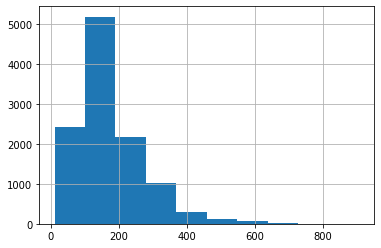

In [113]:
data_arc['time_heat'].hist()

In [114]:
data_arc

,key,start_heat,fin_heat,act_pow,react_pow,last_meas,time_heat
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,2019-05-03 11:30:39,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,2019-05-03 11:30:39,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,2019-05-03 11:30:39,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,2019-05-03 11:30:39,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,2019-05-03 11:30:39,148
...,...,...,...,...,...,...,...
11444,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,0.180213,0.116065,2019-08-06 02:25:31,41
11445,2499,2019-08-06 02:32:56,2019-08-06 02:38:08,1.425867,1.043338,2019-08-06 03:00:28,312
11446,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,0.978407,0.627803,2019-08-06 03:00:28,205
11447,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,1.381264,0.894252,2019-08-06 03:00:28,295


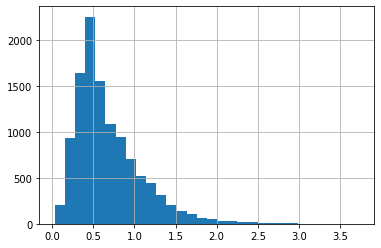

In [115]:
data_arc['act_pow'].hist(bins=30)

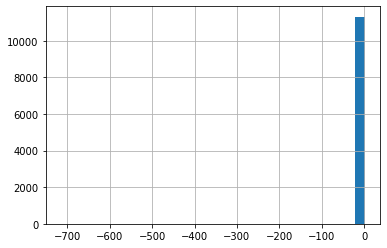

In [116]:
data_arc['react_pow'].hist(bins=30)

Обнаружили выброс

In [117]:
data_arc[data_arc['react_pow'] < 0]

,key,start_heat,fin_heat,act_pow,react_pow,last_meas,time_heat
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924,2019-07-24 00:53:31,109


In [118]:
len(data_arc)

11315

In [119]:
data_arc = data_arc[data_arc['react_pow'] > 0]
len(data_arc)

11314

In [120]:
data_arc

,key,start_heat,fin_heat,act_pow,react_pow,last_meas,time_heat
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,2019-05-03 11:30:39,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,2019-05-03 11:30:39,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,2019-05-03 11:30:39,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,2019-05-03 11:30:39,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,2019-05-03 11:30:39,148
...,...,...,...,...,...,...,...
11444,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,0.180213,0.116065,2019-08-06 02:25:31,41
11445,2499,2019-08-06 02:32:56,2019-08-06 02:38:08,1.425867,1.043338,2019-08-06 03:00:28,312
11446,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,0.978407,0.627803,2019-08-06 03:00:28,205
11447,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,1.381264,0.894252,2019-08-06 03:00:28,295


Введем новые фичи, активная и реактивная энергия. Умножим мощность на время.

In [121]:
data_arc['act_energy'] = data_arc['act_pow'] * data_arc['time_heat']
data_arc['react_energy'] = data_arc['react_pow'] * data_arc['time_heat']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [122]:
df_a = data_arc.groupby('key').agg({'start_heat':'min', 'act_energy' : 'sum', 'react_energy' : 'sum'})
df_a

,start_heat,act_energy,react_energy
key,,,
1,2019-05-03 11:02:14,1207.804249,787.907510
2,2019-05-03 11:34:14,733.816470,487.590677
3,2019-05-03 12:06:54,443.583327,280.936835
4,2019-05-03 12:39:37,670.663327,429.935932
5,2019-05-03 13:11:13,997.496095,664.940090
...,...,...,...
2495,2019-08-06 00:31:05,626.167357,462.572488
2496,2019-08-06 01:00:06,727.868032,485.842067
2497,2019-08-06 01:38:01,427.535518,356.837023


In [123]:
df = df.merge(df_a, on='key', how='left')

In [124]:
df.head()

,key,first_meas,first_temp,last_meas,last_temp,time_btw_meas,start_heat,act_energy,react_energy
0,1,2019-05-03 11:16:18,1571,2019-05-03 11:30:39,1613,861,2019-05-03 11:02:14,1207.804249,787.907510
1,2,2019-05-03 11:37:27,1581,2019-05-03 11:59:12,1602,1305,2019-05-03 11:34:14,733.816470,487.590677
2,3,2019-05-03 12:13:17,1596,2019-05-03 12:34:57,1599,1300,2019-05-03 12:06:54,443.583327,280.936835
3,4,2019-05-03 12:52:57,1601,2019-05-03 12:59:25,1625,388,2019-05-03 12:39:37,670.663327,429.935932
4,5,2019-05-03 13:23:19,1576,2019-05-03 13:36:01,1602,762,2019-05-03 13:11:13,997.496095,664.940090


## Сыпучие материалы

In [125]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2408 entries, 0 to 2407
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      2408 non-null   int64         
 1   bulk_1   199 non-null    datetime64[ns]
 2   bulk_2   13 non-null     datetime64[ns]
 3   bulk_3   965 non-null    datetime64[ns]
 4   bulk_4   814 non-null    datetime64[ns]
 5   bulk_5   53 non-null     datetime64[ns]
 6   bulk_6   444 non-null    datetime64[ns]
 7   bulk_7   14 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   13 non-null     datetime64[ns]
 10  bulk_10  143 non-null    datetime64[ns]
 11  bulk_11  130 non-null    datetime64[ns]
 12  bulk_12  1882 non-null   datetime64[ns]
 13  bulk_13  14 non-null     datetime64[ns]
 14  bulk_14  2137 non-null   datetime64[ns]
 15  bulk_15  1713 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 319.8 KB


Удалим столбец 'bulk_8', во всё датафрейме только одна партия с такой добавкой.

In [126]:
data_bulk_time.drop('bulk_8', axis=1, inplace=True)
data_bulk.drop('bulk_8', axis=1, inplace=True)

In [127]:
t = data_bulk_time.fillna(value='1980-01-01 00:00:00')
t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2408 entries, 0 to 2407
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      2408 non-null   int64 
 1   bulk_1   2408 non-null   object
 2   bulk_2   2408 non-null   object
 3   bulk_3   2408 non-null   object
 4   bulk_4   2408 non-null   object
 5   bulk_5   2408 non-null   object
 6   bulk_6   2408 non-null   object
 7   bulk_7   2408 non-null   object
 8   bulk_9   2408 non-null   object
 9   bulk_10  2408 non-null   object
 10  bulk_11  2408 non-null   object
 11  bulk_12  2408 non-null   object
 12  bulk_13  2408 non-null   object
 13  bulk_14  2408 non-null   object
 14  bulk_15  2408 non-null   object
dtypes: int64(1), object(14)
memory usage: 301.0+ KB


In [128]:
t = t.merge(check_time_df, on='key', how='left')
t

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,last_meas
0,1,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-05-03 11:21:30,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-05-03 11:03:52,1980-01-01 00:00:00,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:30:39
1,2,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-05-03 11:46:38,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-05-03 11:40:20,1980-01-01 00:00:00,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:59:12
2,3,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-05-03 12:31:06,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-05-03 12:09:40,1980-01-01 00:00:00,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:34:57
3,4,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-05-03 12:48:43,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-05-03 12:41:24,1980-01-01 00:00:00,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:59:25
4,5,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-05-03 13:18:50,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-05-03 13:12:56,1980-01-01 00:00:00,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:36:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2403,2495,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-08-06 00:49:21,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-08-06 00:36:47,1980-01-01 00:00:00,2019-08-06 00:32:18,1980-01-01 00:00:00,2019-08-06 00:32:18,2019-08-06 00:32:18,2019-08-06 00:54:42
2404,2496,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-08-06 01:14:16,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-08-06 01:14:16,1980-01-01 00:00:00,2019-08-06 01:06:37,1980-01-01 00:00:00,2019-08-06 01:06:37,2019-08-06 01:06:37,2019-08-06 01:29:52
2405,2497,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-08-06 01:43:02,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-08-06 01:38:54,1980-01-01 00:00:00,2019-08-06 01:38:54,2019-08-06 01:38:53,2019-08-06 01:53:50
2406,2498,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-08-06 02:05:26,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-08-06 02:05:26,1980-01-01 00:00:00,2019-08-06 01:59:25,1980-01-01 00:00:00,2019-08-06 01:59:25,2019-08-06 01:59:25,2019-08-06 02:25:31


In [129]:
t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2408 entries, 0 to 2407
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key        2408 non-null   int64         
 1   bulk_1     2408 non-null   object        
 2   bulk_2     2408 non-null   object        
 3   bulk_3     2408 non-null   object        
 4   bulk_4     2408 non-null   object        
 5   bulk_5     2408 non-null   object        
 6   bulk_6     2408 non-null   object        
 7   bulk_7     2408 non-null   object        
 8   bulk_9     2408 non-null   object        
 9   bulk_10    2408 non-null   object        
 10  bulk_11    2408 non-null   object        
 11  bulk_12    2408 non-null   object        
 12  bulk_13    2408 non-null   object        
 13  bulk_14    2408 non-null   object        
 14  bulk_15    2408 non-null   object        
 15  last_meas  2408 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(14)

In [130]:
bulk_col = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']

In [131]:
for i in bulk_col:
  t[i] = pd.to_datetime(t[i], format='%Y-%m-%d %H:%M:%S')
  z = t[t[i] > t['last_meas']]
  if len(z) > 0:
    print('Вещество: ', i)
    print(z[[i, 'last_meas']])
    for j in z.index:
      print(data_bulk.loc[j,i])
      data_bulk.loc[j,i] = 0
      print(data_bulk.loc[j,i])

Вещество:  bulk_3
                  bulk_3           last_meas
1265 2019-06-19 17:35:26 2019-06-19 17:34:42
1811 2019-07-08 22:13:14 2019-07-08 22:09:51
85
0
46
0
Вещество:  bulk_4
                  bulk_4           last_meas
557  2019-05-25 01:29:11 2019-05-25 01:28:18
1195 2019-06-17 08:49:23 2019-06-17 08:45:16
1492 2019-06-28 05:33:18 2019-06-28 05:32:46
2065 2019-07-24 16:53:54 2019-07-24 16:53:42
101
0
90
0
110
0
19
0
Вещество:  bulk_6
                  bulk_6           last_meas
1451 2019-06-26 14:17:30 2019-06-26 14:14:29
359
0
Вещество:  bulk_10
                 bulk_10           last_meas
1439 2019-06-26 06:51:49 2019-06-26 06:47:47
108
0
Вещество:  bulk_11
                 bulk_11           last_meas
2336 2019-08-03 09:06:24 2019-08-03 09:06:23
49
0


In [132]:
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0,0,0,43,0,0,0,0,0,0,206,0,150,154
1,2,0,0,0,73,0,0,0,0,0,0,206,0,149,154
2,3,0,0,0,34,0,0,0,0,0,0,205,0,152,153
3,4,0,0,0,81,0,0,0,0,0,0,207,0,153,154
4,5,0,0,0,78,0,0,0,0,0,0,203,0,151,152


In [133]:
df = df.merge(data_bulk, on='key', how='left')

In [134]:
df.head()

,key,first_meas,first_temp,last_meas,last_temp,time_btw_meas,start_heat,act_energy,react_energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,2019-05-03 11:16:18,1571,2019-05-03 11:30:39,1613,861,2019-05-03 11:02:14,1207.804249,787.907510,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,2019-05-03 11:37:27,1581,2019-05-03 11:59:12,1602,1305,2019-05-03 11:34:14,733.816470,487.590677,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,2019-05-03 12:13:17,1596,2019-05-03 12:34:57,1599,1300,2019-05-03 12:06:54,443.583327,280.936835,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,2019-05-03 12:52:57,1601,2019-05-03 12:59:25,1625,388,2019-05-03 12:39:37,670.663327,429.935932,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,2019-05-03 13:23:19,1576,2019-05-03 13:36:01,1602,762,2019-05-03 13:11:13,997.496095,664.940090,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


## Газ

In [135]:
data_gas.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [136]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2497 entries, 0 to 2496
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     2497 non-null   int64  
 1   gas     2497 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 58.5 KB


In [137]:
df = df.merge(data_gas, on='key', how='left')

In [138]:
df.head()

,key,first_meas,first_temp,last_meas,last_temp,time_btw_meas,start_heat,act_energy,react_energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas
0,1,2019-05-03 11:16:18,1571,2019-05-03 11:30:39,1613,861,2019-05-03 11:02:14,1207.804249,787.907510,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,2019-05-03 11:37:27,1581,2019-05-03 11:59:12,1602,1305,2019-05-03 11:34:14,733.816470,487.590677,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,2019-05-03 12:13:17,1596,2019-05-03 12:34:57,1599,1300,2019-05-03 12:06:54,443.583327,280.936835,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,2019-05-03 12:52:57,1601,2019-05-03 12:59:25,1625,388,2019-05-03 12:39:37,670.663327,429.935932,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,2019-05-03 13:23:19,1576,2019-05-03 13:36:01,1602,762,2019-05-03 13:11:13,997.496095,664.940090,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692


## Проволока

In [139]:
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
data_wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2373 entries, 0 to 2372
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     2373 non-null   int64 
 1   wire_1  2349 non-null   object
 2   wire_2  833 non-null    object
 3   wire_3  39 non-null     object
 4   wire_4  12 non-null     object
 5   wire_6  45 non-null     object
 6   wire_7  4 non-null      object
 7   wire_8  13 non-null     object
 8   wire_9  28 non-null     object
dtypes: int64(1), object(8)
memory usage: 185.4+ KB


In [142]:
t = data_wire_time.fillna(value='1980-01-01 00:00:00')
t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2373 entries, 0 to 2372
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     2373 non-null   int64 
 1   wire_1  2373 non-null   object
 2   wire_2  2373 non-null   object
 3   wire_3  2373 non-null   object
 4   wire_4  2373 non-null   object
 5   wire_6  2373 non-null   object
 6   wire_7  2373 non-null   object
 7   wire_8  2373 non-null   object
 8   wire_9  2373 non-null   object
dtypes: int64(1), object(8)
memory usage: 185.4+ KB


In [143]:
t = t.merge(check_time_df, on='key', how='left')
t

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,last_meas
0,1,2019-05-03 11:11:41,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-05-03 11:30:39
1,2,2019-05-03 11:46:10,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-05-03 11:59:12
2,3,2019-05-03 12:13:47,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-05-03 12:34:57
3,4,2019-05-03 12:48:05,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-05-03 12:59:25
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-05-03 13:36:01
...,...,...,...,...,...,...,...,...,...,...
2368,2495,2019-08-06 00:36:13,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-08-06 00:54:42
2369,2496,2019-08-06 01:13:33,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-08-06 01:29:52
2370,2497,2019-08-06 01:42:27,2019-08-06 01:42:51,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-08-06 01:53:50
2371,2498,2019-08-06 02:04:20,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,1980-01-01 00:00:00,2019-08-06 02:25:31


In [144]:
t.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7',
       'wire_8', 'wire_9', 'last_meas'],
      dtype='object')

In [145]:
wire_col = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7',
       'wire_8', 'wire_9']

In [146]:
for i in wire_col:
  t[i] = pd.to_datetime(t[i], format='%Y-%m-%d %H:%M:%S')
  z = t[t[i] > t['last_meas']]
  if len(z) > 0:
    print('Материал проволоки: ', i)
    print(z[[i, 'last_meas']])
    for j in z.index:
      print(data_wire.loc[j,i])
      data_wire.loc[j,i] = 0
      print(data_wire.loc[j,i])

Материал проволоки:  wire_1
                  wire_1           last_meas
1433 2019-06-26 14:14:50 2019-06-26 14:14:29
165.43800299999995
0.0
Материал проволоки:  wire_2
                  wire_2           last_meas
1176 2019-06-17 08:49:29 2019-06-17 08:45:16
1433 2019-06-26 14:18:01 2019-06-26 14:14:29
9.13848
0.0
51.814877
0.0


In [147]:
data_wire.loc[1433,'wire_1']

0.0

In [148]:
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [149]:
df = df.merge(data_wire, on='key', how='left')

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   key            2477 non-null   int64         
 1   first_meas     2477 non-null   datetime64[ns]
 2   first_temp     2477 non-null   int64         
 3   last_meas      2477 non-null   datetime64[ns]
 4   last_temp      2477 non-null   int64         
 5   time_btw_meas  2477 non-null   int64         
 6   start_heat     2475 non-null   datetime64[ns]
 7   act_energy     2475 non-null   float64       
 8   react_energy   2475 non-null   float64       
 9   bulk_1         2408 non-null   float64       
 10  bulk_2         2408 non-null   float64       
 11  bulk_3         2408 non-null   float64       
 12  bulk_4         2408 non-null   float64       
 13  bulk_5         2408 non-null   float64       
 14  bulk_6         2408 non-null   float64       
 15  bulk_7         2408 n

In [151]:
df[df['act_energy'].isnull()]

,key,first_meas,first_temp,last_meas,last_temp,time_btw_meas,start_heat,act_energy,react_energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
192,195,2019-05-10 14:10:23,1583,2019-05-10 14:10:23,1583,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.374436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
276,279,2019-05-13 23:07:28,1603,2019-05-13 23:07:28,1603,0,NaT,NaN,NaN,0.0,0.0,0.0,0.0,0.0,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.232359,99.066236,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Пропуски в act_energy и react_energy заменим нулями, партия не нагревалась электродами.  
Аналогичная ситуация с пропусками в фичах сыпучих материалов, проволоке и инертном газе. Пропуск говорит о нулевой добавке.


In [152]:
df.columns

Index(['key', 'first_meas', 'first_temp', 'last_meas', 'last_temp',
       'time_btw_meas', 'start_heat', 'act_energy', 'react_energy', 'bulk_1',
       'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_9',
       'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'gas',
       'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_8',
       'wire_9'],
      dtype='object')

In [153]:
t = ['act_energy', 'react_energy', 'bulk_1',
       'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_9',
       'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'gas',
       'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_8',
       'wire_9']

In [154]:
for i in t:
  df[i] = df[i].fillna(value=0)

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   key            2477 non-null   int64         
 1   first_meas     2477 non-null   datetime64[ns]
 2   first_temp     2477 non-null   int64         
 3   last_meas      2477 non-null   datetime64[ns]
 4   last_temp      2477 non-null   int64         
 5   time_btw_meas  2477 non-null   int64         
 6   start_heat     2475 non-null   datetime64[ns]
 7   act_energy     2477 non-null   float64       
 8   react_energy   2477 non-null   float64       
 9   bulk_1         2477 non-null   float64       
 10  bulk_2         2477 non-null   float64       
 11  bulk_3         2477 non-null   float64       
 12  bulk_4         2477 non-null   float64       
 13  bulk_5         2477 non-null   float64       
 14  bulk_6         2477 non-null   float64       
 15  bulk_7         2477 n

In [156]:
df.head()

,key,first_meas,first_temp,last_meas,last_temp,time_btw_meas,start_heat,act_energy,react_energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:16:18,1571,2019-05-03 11:30:39,1613,861,2019-05-03 11:02:14,1207.804249,787.907510,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-05-03 11:37:27,1581,2019-05-03 11:59:12,1602,1305,2019-05-03 11:34:14,733.816470,487.590677,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019-05-03 12:13:17,1596,2019-05-03 12:34:57,1599,1300,2019-05-03 12:06:54,443.583327,280.936835,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019-05-03 12:52:57,1601,2019-05-03 12:59:25,1625,388,2019-05-03 12:39:37,670.663327,429.935932,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019-05-03 13:23:19,1576,2019-05-03 13:36:01,1602,762,2019-05-03 13:11:13,997.496095,664.940090,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
t = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_9',
       'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

In [158]:
for i in t:
  df[i] = df[i].astype('int')

In [159]:
df.head()

,key,first_meas,first_temp,last_meas,last_temp,time_btw_meas,start_heat,act_energy,react_energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:16:18,1571,2019-05-03 11:30:39,1613,861,2019-05-03 11:02:14,1207.804249,787.907510,0,0,0,43,0,0,0,0,0,0,206,0,150,154,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-05-03 11:37:27,1581,2019-05-03 11:59:12,1602,1305,2019-05-03 11:34:14,733.816470,487.590677,0,0,0,73,0,0,0,0,0,0,206,0,149,154,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019-05-03 12:13:17,1596,2019-05-03 12:34:57,1599,1300,2019-05-03 12:06:54,443.583327,280.936835,0,0,0,34,0,0,0,0,0,0,205,0,152,153,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019-05-03 12:52:57,1601,2019-05-03 12:59:25,1625,388,2019-05-03 12:39:37,670.663327,429.935932,0,0,0,81,0,0,0,0,0,0,207,0,153,154,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019-05-03 13:23:19,1576,2019-05-03 13:36:01,1602,762,2019-05-03 13:11:13,997.496095,664.940090,0,0,0,78,0,0,0,0,0,0,203,0,151,152,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


Перед обучением проверим признаки на мультиколлинеарность

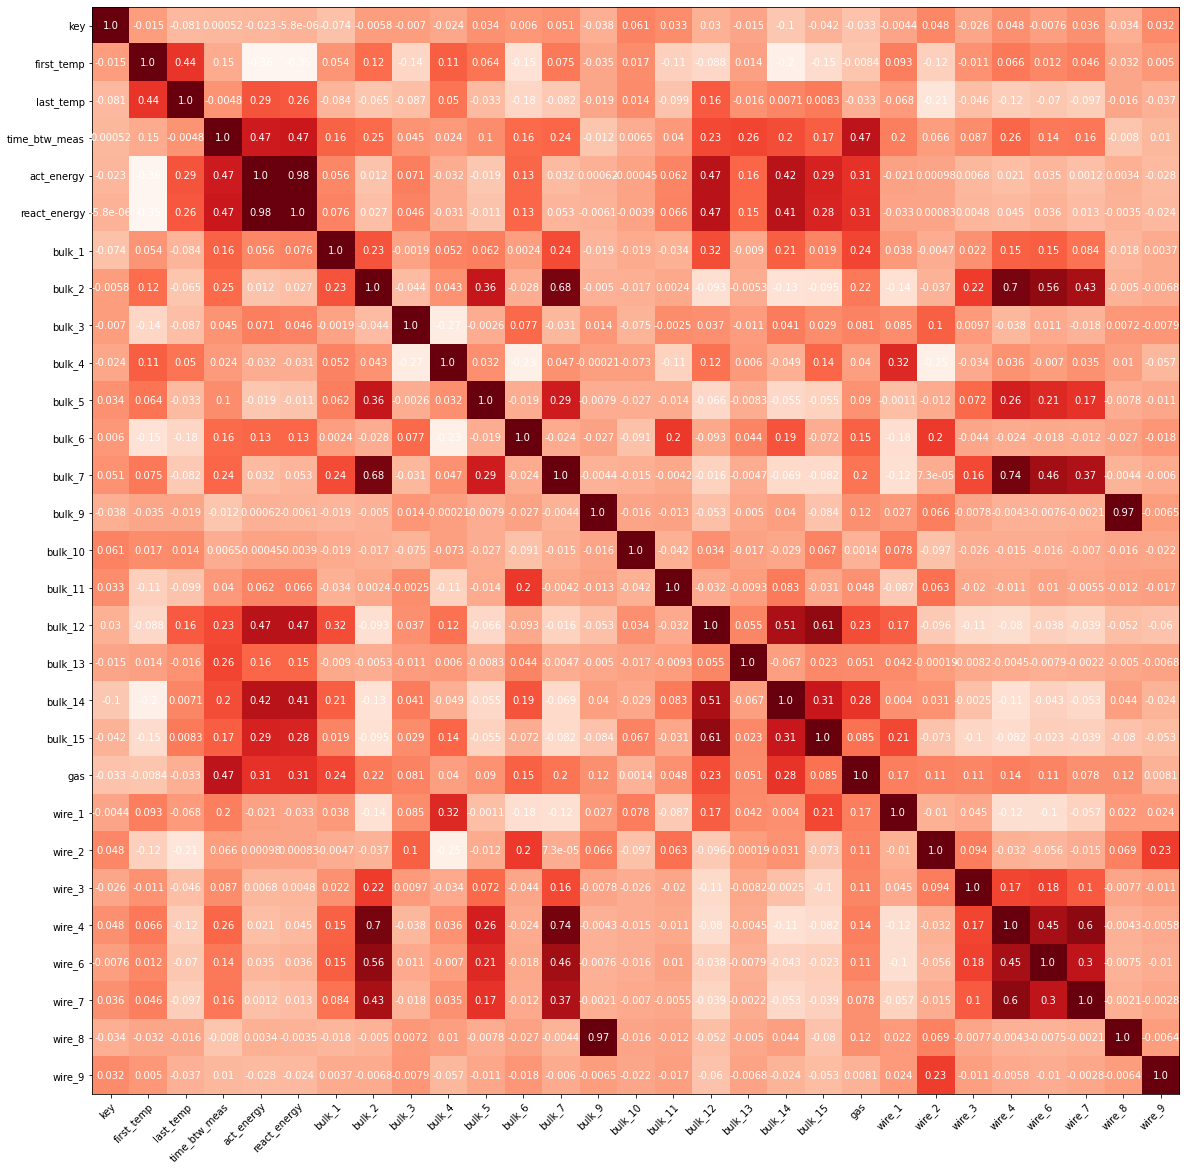

In [160]:
df_knn = df.copy()
corr_heatmap_data = df_knn.corr()

fig, ax = plt.subplots(figsize=(20,20))
ax.set_xticks(np.arange(len(corr_heatmap_data.index)))
ax.set_yticks(np.arange(len(corr_heatmap_data.index)))

ax.set_xticklabels(corr_heatmap_data.index)
ax.set_yticklabels(corr_heatmap_data.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

data = corr_heatmap_data.values

for i in range(len(corr_heatmap_data.index)):
    for j in range(len(corr_heatmap_data.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]),
                       ha="center", va="center", color="w")
        
im = ax.imshow(corr_heatmap_data.corr(), cmap='Reds')

Очень сильная зависимость у двух пар признаков: активная и реактивная энергии, wire_8 и bulk_9.  
При обучении не будем использовать react_energy и bulk_9.

Основная таблица готова, можно начинать обучение моделей.

# Обучение моделей

In [161]:
train = df.sample(frac=0.75, random_state=69).copy()
test = df[~df.index.isin(train.index)]

In [162]:
len(df) == len(train) + len(test)

True

In [163]:
df.columns

Index(['key', 'first_meas', 'first_temp', 'last_meas', 'last_temp',
       'time_btw_meas', 'start_heat', 'act_energy', 'react_energy', 'bulk_1',
       'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_9',
       'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'gas',
       'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_8',
       'wire_9'],
      dtype='object')

In [164]:
df.head(3)

,key,first_meas,first_temp,last_meas,last_temp,time_btw_meas,start_heat,act_energy,react_energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:16:18,1571,2019-05-03 11:30:39,1613,861,2019-05-03 11:02:14,1207.804249,787.907510,0,0,0,43,0,0,0,0,0,0,206,0,150,154,29.749986,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-05-03 11:37:27,1581,2019-05-03 11:59:12,1602,1305,2019-05-03 11:34:14,733.816470,487.590677,0,0,0,73,0,0,0,0,0,0,206,0,149,154,12.555561,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019-05-03 12:13:17,1596,2019-05-03 12:34:57,1599,1300,2019-05-03 12:06:54,443.583327,280.936835,0,0,0,34,0,0,0,0,0,0,205,0,152,153,28.554793,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
features = ['first_temp', 'time_btw_meas', 'act_energy', 'bulk_1', 'bulk_4','bulk_6',
       'bulk_12', 'bulk_14', 'gas', 'wire_1', 'wire_2']
#features = ['first_temp', 'time_btw_meas', 'act_energy', 'bulk_1',
#       'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
#       'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15', 'gas',
#       'wire_1', 'wire_2']
target  = ['last_temp']

## Линейная регрессия

In [166]:
model_lr = LinearRegression()
model_lr.fit(train[features],  train[target])
pred = model_lr.predict(train[features])
MAE = mae(pred, train[target])
print('MAE на обучающей выборке =', MAE)

MAE на обучающей выборке = 7.27608405293631


## CatBoost

In [167]:
!pip install catboost

In [168]:
from catboost import CatBoostRegressor

In [169]:
param = {'l2_leaf_reg': [1, 3, 5],
         'max_depth': range (3, 7, 2),
         'learning_rate': [0.03, 0.05, 0.8]}

cb = CatBoostRegressor(loss_function='MAE', random_state=42, iterations=2000)

In [170]:
from sklearn.model_selection import GridSearchCV

In [171]:
model_cb = GridSearchCV(cb, param, cv=5, scoring='neg_mean_absolute_error', n_jobs=4, verbose=3)
model_cb.fit(train[features],  train[target])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  6.9min finished


0:	learn: 9.9873564	total: 48.9ms	remaining: 1m 37s
1:	learn: 9.9060238	total: 51.2ms	remaining: 51.2s
2:	learn: 9.8436365	total: 53.4ms	remaining: 35.5s
3:	learn: 9.7671657	total: 55.6ms	remaining: 27.7s
4:	learn: 9.6921999	total: 57.7ms	remaining: 23s
5:	learn: 9.5952747	total: 59.8ms	remaining: 19.9s
6:	learn: 9.5111452	total: 61.9ms	remaining: 17.6s
7:	learn: 9.4183933	total: 64.1ms	remaining: 16s
8:	learn: 9.3453584	total: 66.3ms	remaining: 14.7s
9:	learn: 9.2826064	total: 68.4ms	remaining: 13.6s
10:	learn: 9.2223066	total: 70.5ms	remaining: 12.8s
11:	learn: 9.1688165	total: 72.7ms	remaining: 12s
12:	learn: 9.0817977	total: 74.8ms	remaining: 11.4s
13:	learn: 8.9958276	total: 77ms	remaining: 10.9s
14:	learn: 8.9196356	total: 79.1ms	remaining: 10.5s
15:	learn: 8.8801186	total: 81.3ms	remaining: 10.1s
16:	learn: 8.7942794	total: 83.4ms	remaining: 9.73s
17:	learn: 8.7560457	total: 85.5ms	remaining: 9.41s
18:	learn: 8.6785969	total: 87.7ms	remaining: 9.14s
19:	learn: 8.6089643	total: 9

GridSearchCV(cv=5, error_score=nan,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f1719320050>,
             iid='deprecated', n_jobs=4,
             param_grid={'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.03, 0.05, 0.8],
                         'max_depth': range(3, 7, 2)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=3)

In [172]:
model_cb.best_params_, model_cb.best_score_

({'l2_leaf_reg': 3, 'learning_rate': 0.03, 'max_depth': 5},
 -5.8228743905222276)

# Анализ важности признаков

Посмотрим, какие признаки для модели оказались самыми важными

In [173]:
model_cb.best_estimator_.feature_importances_

array([32.83705108,  8.0713946 , 22.82841976,  2.37852954,  2.68260837,
        3.40075862,  4.02335451,  3.10818205,  2.40201656, 15.27393721,
        2.99374769])

In [174]:
fi = pd.DataFrame({'w':model_cb.best_estimator_.feature_importances_,'name':features})
fi.sort_values('w',ascending=False)

,w,name
0,32.837051,first_temp
2,22.828420,act_energy
9,15.273937,wire_1
1,8.071395,time_btw_meas
6,4.023355,bulk_12
5,3.400759,bulk_6
7,3.108182,bulk_14
10,2.993748,wire_2
4,2.682608,bulk_4
8,2.402017,gas


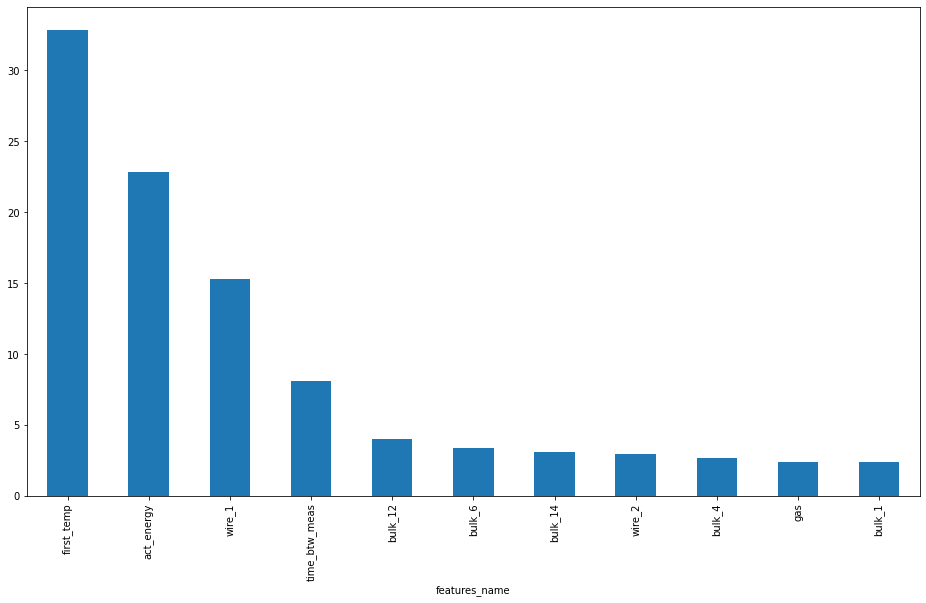

In [175]:
features_weight = pd.DataFrame({'features_name':features,'weight':model_cb.best_estimator_.feature_importances_}).sort_values('weight', ascending=False)
features_weight.set_index('features_name')['weight'].plot(kind='bar', figsize=(16, 9))

In [176]:
! pip install shap

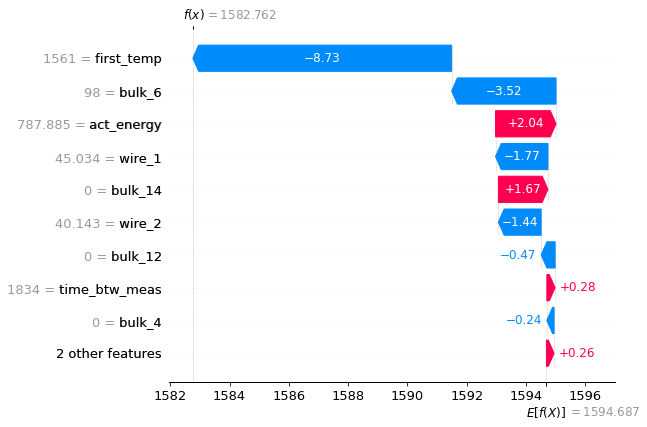

In [177]:
import shap
explainer = shap.Explainer(model_cb.best_estimator_)
shap_values = explainer(train[features])
shap.plots.waterfall(shap_values[0])

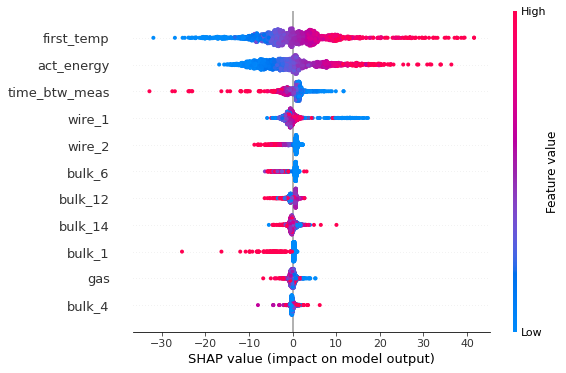

In [178]:
shap.summary_plot(shap_values, train[features])

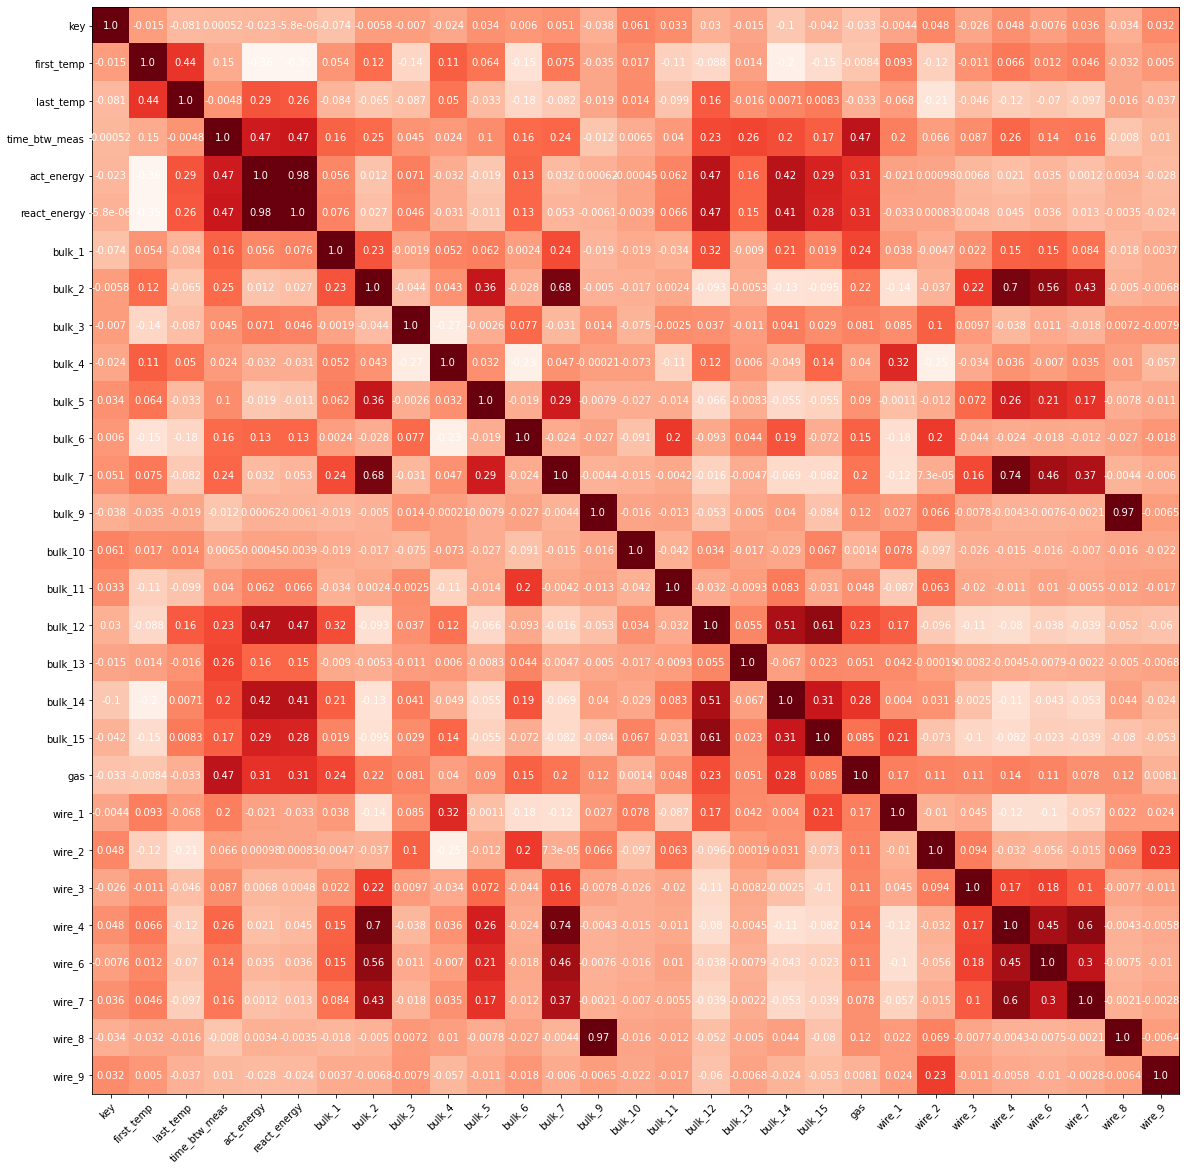

In [179]:
df_knn = df.copy()
corr_heatmap_data = df_knn.corr()

fig, ax = plt.subplots(figsize=(20,20))
ax.set_xticks(np.arange(len(corr_heatmap_data.index)))
ax.set_yticks(np.arange(len(corr_heatmap_data.index)))

ax.set_xticklabels(corr_heatmap_data.index)
ax.set_yticklabels(corr_heatmap_data.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

data = corr_heatmap_data.values

for i in range(len(corr_heatmap_data.index)):
    for j in range(len(corr_heatmap_data.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]),
                       ha="center", va="center", color="w")
im = ax.imshow(corr_heatmap_data.corr(), cmap='Reds')        

Исключим несущественные фичи('bulk_3', 'bulk_5', 'bulk_10', 'bulk_11') и обучим модели заново.  
(повторно запускаем обучение моделей на сокращенном списке признаков)

# Показатели на тестовых данных

##  Линейная регрессия

In [180]:
pred = model_lr.predict(test[features])
MAE = mae(pred, test[target])
print('MAE на тестовой выборке =', MAE)

MAE на тестовой выборке = 7.109449760349231


## CatBoost

In [181]:
pred = model_cb.predict(test[features])
MAE = mae(pred, test[target])
print('MAE на тестовой выборке =', MAE)

MAE на тестовой выборке = 5.879596502152057


# Итоги работы

Планировалось:
- все партии начиная с 2500 не имеют данных о последнем замере температуры, удалить из всех таблиц партии 2500+; (сделано)
- провести запланированные преобразования в каждой из таблиц; (сделано)
- собрать общую таблицу, мерджить по ключам; (сделано)
- обнулить информацию о процессах, происходящих позже последнего замера температуры; (сделано)
- обучить модели LinearRegression, RandomForestRegressor, CatBoostRegressor, LGBMRegressor, XGBRegressor; (сделано частично)
- получить MAE < 6.0, 7sp; (сделано)


В ходе работы, прошли по следующим этапам:
1. Иследовательский анализ данных
  - просмотрели таблицы
  - построили графики распредления
  - сводные таблицы
  - по каждой таблице составили отдельный план действий
  - составили общий план работы
2. Предобработка данных 
  - удалили партии в которых отсутствовал целевой признак
  - переименовали столбцы
  - заполнили пропуски
  - заменили типы данных
  - удалили пустые признаки
3. Общая таблица
  - сгенерировали новые признаки
  - собрали общую таблицу
  - проверили фичи на мультиколлинеарность
  - выделили фичи, которые будут использоваться в обучении моделей
4. Обучение моделей
  - обучили линейную регрессию, MAE на обучающей выборке составила 8.17
  - обучили CatBoost, MAE на обучающей выборке составила 6.15
5. Анализ важности признаков
  - выделили важные признаки
  - исключили несущественные признаки
  - заново обучили модели
  - MAE линейной регрессии снизилась до 7.27
  - MAE CatBoost'a снизилась до 5.82
6. Проверили MAE на тестовой выборке
  - MAE на тестовой выборке составила 7.10
  - MAE на тестовой выборке составила 5.87

По результатам работы выявили следующие факты:
- единая технология производства не всегда соблюдается;
- разница в температуре стали в отдельных партиях доходит до 500 градусов. Учитывая тот факт, что температура плавления стали составляет 1450 - 1520 грудасов, очень странно выглядят случаи, когда температура материала ниже 1450 градусов.
- в отдельных партиях происходило до 16ти этапов нагревания, что приводит к дополнительным энергозатратам;
- в отдельных партиях после последнего замера производились дополнительные процедуры(добавление сыпучих материалов, проволоки, нагревание)

Все запланированные пункты плана были выполнены.   
Отпала необходимость в обучении моделей RandomForestRegressor, LGBMRegressor, XGBRegressor.  
Модель на базе CatBoostRegressor выполнила поставленную задачу (MAE < 6.0) на идеальном уровне, **MAE = 5.87**.  
При необходимости, ошибку можно дополнительно снизить.   
Вот несколько потенциально интересных действий которые могут позволить снизить MAE:
- обучение дополнительных моделей, например, RandomForestRegressor, LGBMRegressor, XGBRegressor и пр.;
- дополнительная очистка данных от выбросов. Выбросы присутствуют в большинстве признаков;
- увеличение количества данных. После очистки данных, датасет остался совсем небольшим, менее 2500 наблюдений;
- увеличение количества итераций в обучении моделей;

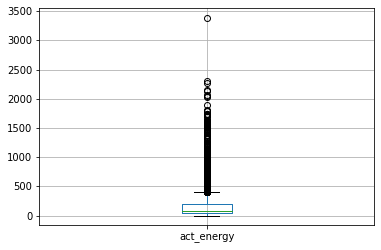

In [182]:
data_arc.boxplot('act_energy')

In [183]:
data_arc['act_energy'].describe()

count    11314.000000
mean       157.795765
std        207.745066
min          0.330021
25%         44.968742
50%         83.333269
75%        190.172947
max       3384.557674
Name: act_energy, dtype: float64

На графике выше видно, что распределение энергозатрат имеет очень большой хвост. Медианный расход меньше среднего в два раза, что говорит о сильных выбросах.   
Если ставится задача по снижению энергопотребления, то необходимо в первую очередь обратить внимание на те партии, в которых расход энергии существенно превышает медианный.  
Необходимо рассмотреть возможность исключить такие действиях в партиях, которые приводят к нецелесообразному увеличению потребления. Установить предпочтительный/возможный алгоритмы обработки. 